# Building the model
A static model is a Python object that represents a Bayesian model with static parameter 𝜃. <br>
We are considering a model where the observations are 𝑌𝑡∼𝑁(𝜇,𝜎^2). The parameter is 𝜃=(𝜇,𝜎)

In [13]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import numpy as np

import particles
from particles import smc_samplers as ssp
from particles import distributions as dists

class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta['mu'],
                                 scale=theta['sigma'])

In [17]:
T = 1000
my_data = stats.norm.rvs(loc=3.14, size=T)  # simulated data
my_prior = dists.StructDist({'mu': dists.Normal(scale=10.),
                             'sigma': dists.Gamma()})

In [7]:
my_static_model = ToyModel(data=my_data, prior=my_prior)

Object my_static_model has enough information to define the posterior distribution(s) of the model (given all data, or part of the data). In fact, it inherits from StaticModel method logpost, which evaluates (for a collection of 𝜃 values) the posterior log-density at any time 𝑡 (meaning given data 𝑦0:𝑡).

In [21]:
thetas = my_prior.rvs(size=5)
p = my_static_model.logpost(thetas, t=2)  # if t is omitted, gives the full posterior
thetas

array([(-10.6688881 , 3.98144845), ( 13.32292358, 2.39496789),
       ( 10.70773259, 1.45241263), (-29.54582253, 0.96203809),
       (-13.24768057, 1.50136164)],
      dtype=[('mu', '<f8'), ('sigma', '<f8')])

# Iterated Batch Importance Sampling

In [11]:
my_ibis = ssp.IBIS(my_static_model)
my_alg = particles.SMC(fk=my_ibis, N=1000, store_history=True) #with store_history the algorithm will store particles
import time
start_time = time.time()
my_alg.run()
print("--- IBIS running took %s seconds ---" % (time.time() - start_time))

--- IBIS running took 3.7045230865478516 seconds ---


Now plot the posterior distributions at different timesteps

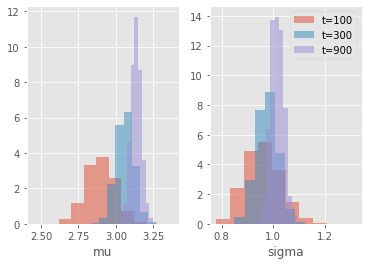

In [10]:
plt.style.use('ggplot')
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    for t in [100, 300, 900]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgt[t].W, label="t=%i" % t, alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend();

Once the algorithm is run, my_smc.X contains the N final paticles and is a ThetaParticles object, with attributes:
<ul>
    <li> theta: a structured array: as mentioned above, this is an array with fields; i.e. my_smc.X.theta['mu'] is a (N,) array that contains the the 𝜇−component of the 𝑁 particles;
    <li> lpost: a (N,) numpy array that contains the target (posterior) log-density of each of the N particles;
    <li> acc_rates: a list of the acceptance rates of the resample-move steps.
</ul>

['18.58%', '23.47%', '26.02%', '28.72%', '33.26%', '35.37%', '34.30%', '34.90%', '34.97%', '35.22%', '35.08%', '35.66%', '36.54%', '37.07%', '36.62%']


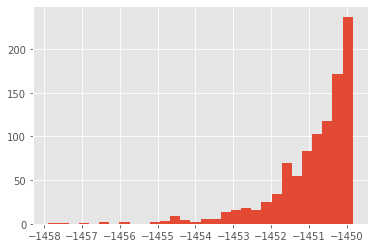

In [14]:
print(["%2.2f%%" % (100 * np.mean(r)) for r in my_alg.X.acc_rates])
plt.hist(my_alg.X.lpost, 30);

Class IBIS takes as an optional argument mh_options, a dictionary which may contain the following (key, values) pairs:
<ul>
    <li>'type_prop': either 'random walk' or 'independent’; in the latter case, an independent Gaussian proposal is used. The mean of the Gaussian is set to the weighted mean of the particles. The variance is set to scale times the weighted variance of the particles.
    <li>'scale’: the scale of the proposal (as explained above).
    <li>'nsteps': number of steps. If set to 0, the adaptive strategy described above is used.
</ul>

In [15]:
alt_ibis = ssp.IBIS(my_static_model, mh_options={'type_prop': 'independent',
                                                 'nsteps': 10})
alt_alg = particles.SMC(fk=alt_ibis, N=1000, ESSrmin=0.2)
start_time = time.time()
alt_alg.run()
print("--- Independent proposal IBIS running took %s seconds ---" % (time.time() - start_time))

--- Independent proposal IBIS running took 3.065840244293213 seconds ---


Plot the ESS, as we changed the threshold.

Text(0, 0.5, 'ESS')

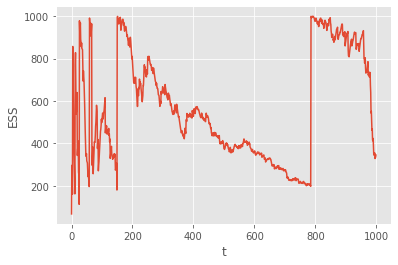

In [16]:
plt.plot(alt_alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')